# 7. Analysis of enumeration and generation results

In this notebook we analyse and compare the enumerated and generated molecules on the MetaNetX and eMolecules datasets.

In [1]:
import ast
import math
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from rdkit import Chem

from molsig.enumerate_signature import save_mol_plot

In [2]:
from IPython.display import display


def plot_mol(mol):
    if type(mol) == str:
        mol = Chem.MolFromSmiles(mol)
    display(mol)

# Results path

In [3]:
path_results = "C:/Users/meyerp/Documents/INRAE/Diophantine/Enumération/github/results/"

# Compatibility enumeration and generation

In [4]:
for database in ["metanetx", "emolecules"]:
    df_results_enum = pd.read_excel(path_results + "RevSig_" + database + ".xlsx")
    smis_enum = list(set(df_results_enum["smi"]))
    for top in ["top001", "top010", "top100"]:
        df_results_gen = pd.read_csv(
            path_results + "generative/" + database + "." + top + ".results.refined.tsv", sep="\t"
        )
        smis_gen = list(set(df_results_gen["Query SMILES"]))

        print(database, top, smis_enum == smis_gen)

metanetx top001 True
metanetx top010 True
metanetx top100 True
emolecules top001 True
emolecules top010 True
emolecules top100 True


# Database choice

In [5]:
database_chosen = "metanetx"
# database_chosen = "emolecules"

# Statistics enumeration

In [6]:
df_results = pd.read_excel(path_results + "RevSig_" + database_chosen + ".xlsx")

In [7]:
print(f"Results shape: {df_results.shape}")
missing_ids = [i for i in range(10000) if i not in list(df_results["ID"])]
print(f"Missing ids: {missing_ids}")
df_results.head()

Results shape: (10000, 15)
Missing ids: []


,ID,smi,wt,Nsig,NsigTrue,FoundSig,Nmol,Foundmol,CT ecfp_sig,CT sig_mol,CT ecfp_mol,CT solve_partitions,ThresholdPart,ThresholdRec,NewSmiles
0,0,CCN1C(=O)OC(C)(C)C1=O,157.073893,1,1,1,1,1,1.342747,0.018277,1.361032,0.001598,False,False,set()
1,1,CC(=O)NC[C@H](O)c1c[nH]c(C(=O)[O-])c1C(=O)[O-],254.054983,1,1,1,1,1,1.493630,0.029611,1.523250,0.003635,False,False,set()
2,2,Nc1nc(N2CCC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,286.154209,1,1,1,1,1,1.543445,0.044019,1.587476,0.011138,False,False,set()
3,3,C[C@H](CO)C(=O)O[C@@H]1O[C@H](C(=O)O)[C@H](O)[...,280.079432,1,1,1,2,1,1.570595,0.081484,1.652089,0.023897,False,False,{'C[C@H](CO)C(=O)O[C@@H]1O[C@H](C(=O)O)[C@H](O...
4,4,C[C@H](CCCCCCCCCCN(C)C)[C@H](CC(=O)[O-])C(=O)[O-],327.242056,1,1,1,1,1,1.613742,18.629302,20.243055,0.026824,False,True,set()


In [8]:
recovery_ecfp_sig = np.mean(list(df_results["FoundSig"]))
recovery_ecfp_mol = np.mean(list(df_results["Foundmol"]))
print(f"Recovery % ecfp to sig: {round(100 * recovery_ecfp_sig, 2)}")
print(f"Recovery % ecfp to mol: {round(100 * recovery_ecfp_mol, 2)}")

Recovery % ecfp to sig: 99.92
Recovery % ecfp to mol: 99.66


In [9]:
df_results_nsigtrue = df_results[df_results["NsigTrue"] > 1].shape[0]
nb_signatures_enumerated = 0
for i in range(df_results.shape[0]):
    nb_signatures_enumerated += max(
        list(df_results["NsigTrue"])[i] - list(df_results["FoundSig"])[i], 0
    )
nb_molecules_enumerated = sum(list(df_results["Nmol"]))
print(f"Nb new signatures enumerated: {nb_signatures_enumerated}")
print(f"Nb molecules enumerated: {nb_molecules_enumerated}")

Nb new signatures enumerated: 12
Nb molecules enumerated: 21291


In [10]:
nb_molecules_enumerating_10_or_more = df_results[df_results["Nmol"] >= 10].shape[0]
print(f"Nb ECFP enumerating 10 or more molecules: {nb_molecules_enumerating_10_or_more}")

df_results.sort_values(by=["Nmol"], ascending=False).head()

Nb ECFP enumerating 10 or more molecules: 175


,ID,smi,wt,Nsig,NsigTrue,FoundSig,Nmol,Foundmol,CT ecfp_sig,CT sig_mol,CT ecfp_mol,CT solve_partitions,ThresholdPart,ThresholdRec,NewSmiles
7568,7568,C1CCC[C@H]2CCCN3CC[C@@H](CCCCCC[C@@H]4CCCN5CC[...,446.387229,1,1,1,3558,1,5118.024626,235.782266,5353.807029,5116.486669,True,True,{'C1CCC[C@@H]2CCCCCC[C@@H]3CCC[N@]4CC[C@@H]5CC...
892,892,C=C1CC[C@H]2[C@]3(C)CC[C@H]4C(C)(C)CCC[C@]4(C)...,358.323566,1,1,1,352,1,3.095246,37.122306,40.217780,1.319064,False,True,{'C=C1CC[C@H]2[C@@]3(C)CCCC(C)(C)[C@@H]4CC[C@@...
8122,8122,O=C1CC[C@H]2[C@H]3CC[C@H]4CCCC[C@H]4[C@H]3CC[C...,262.193280,1,1,1,288,1,16.586380,10.778446,27.364848,15.261256,False,False,{'O=C1CC[C@@H]2[C@@H]3CCCC[C@H]4[C@H]2CC[C@@H]...
5952,5952,CCCCCC[C@H](C)CCCCCCCCC(=O)OCCCCCCCCCCCC(C)C,466.474981,1,1,1,266,1,1542.499364,55.419640,1597.919027,1540.755201,True,True,{'CCCCCCCCCOC(=O)CCCCCCCC[C@@H](C)CCCCCCCCC(C)...
4363,4363,C[C@H]1C(=O)CC[C@@H]2[C@]1(C)CC[C@H]1[C@@]2(C)...,426.386166,1,1,1,192,1,16.829958,30.514116,47.344095,14.677656,False,True,{'C[C@H]1C(=O)CC[C@H]2[C@]1(C)CC[C@@]1(C)[C@@H...


In [11]:
ct_solve_partitions = np.mean(list(df_results["CT solve_partitions"]))
ct_ecfp_sig = np.mean(list(df_results["CT ecfp_sig"]))
ct_sig_mol = np.mean(list(df_results["CT sig_mol"]))
ct_ecfp_mol = np.mean(list(df_results["CT ecfp_mol"]))
print(f"Mean CT solve_partitions: {round(ct_solve_partitions, 2)}")
print(f"Mean CT ecfp_sig: {round(ct_ecfp_sig, 2)}")
print(f"Mean CT sig_mol: {round(ct_sig_mol, 2)}")
print(f"Mean CT ecfp_mol: {round(ct_ecfp_mol, 2)}")

Mean CT solve_partitions: 4.36
Mean CT ecfp_sig: 6.15
Mean CT sig_mol: 3.13
Mean CT ecfp_mol: 9.28


In [12]:
nb_at_least_one_timeout = df_results[
    df_results["ThresholdPart"] | df_results["ThresholdRec"]
].shape[0]
print(f"Nb at least one timeout: {nb_at_least_one_timeout}")

Nb at least one timeout: 783


## Unrecovered molecules

In [13]:
mol_not_recovered = list(df_results[df_results["Foundmol"] == 0]["smi"])
nb_mol_not_recovered = len(mol_not_recovered)
print(f"Nb molecules not recovered: {nb_mol_not_recovered}")

Nb molecules not recovered: 34


OC[C@H]1O[C@@H](O[C@H]2O[C@H](CO)[C@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@H]1O


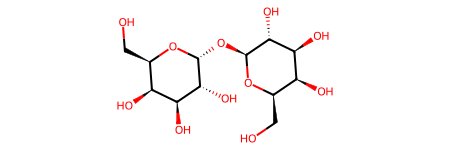

c1ccc(-c2nnc(-c3ccncc3)nc2-c2ccccc2)cc1


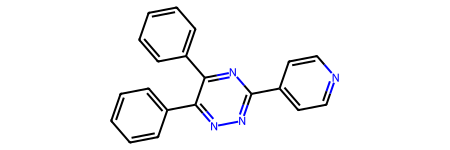

CCCCCC(=O)O[C@H](COCCCCCCCCCCC(C)C)COP(=O)([O-])[O-]


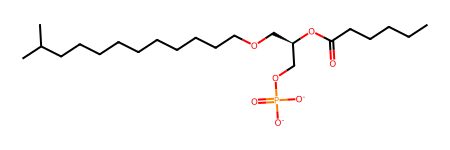

O=c1ccc2cc3ccc4cccc5ccc(c2o1)c3c45


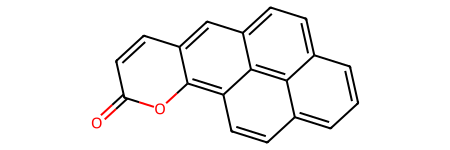

N[C@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccc(O)cc1)C(=O)O


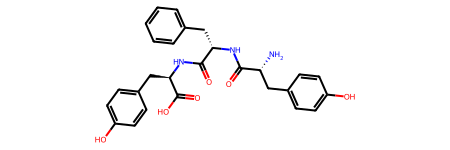

CCCCC/C=C\C/C=C\CCCCCCCCCCCCC


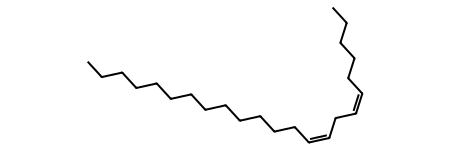

O=C(CN1CCOCC1)N[C@H]1CC[C@@H](CCn2cc(C3CCCCC3)nn2)O[C@H]1CO


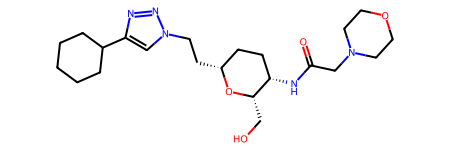

OC[C@@H]1O[C@H](OC[C@@H]2O[C@H](O)[C@@H](O[C@H]3O[C@@H](CO)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)[C@H](O)[C@@H](O)[C@H]1O


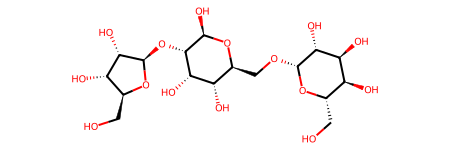

COc1ccc2c3c(n(C)c2c1)[C@H](CO)N(CC1CC1)CC31CCN(C(=O)NC2CCCC2)CC1


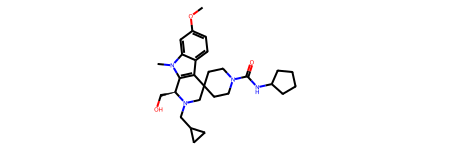

C[C@@H]1O[C@@H](O[C@@H](C=O)[C@@H](O[C@H]2O[C@H](CO)[C@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@H](O)CO)[C@@H](O)[C@H](O)[C@@H]1O


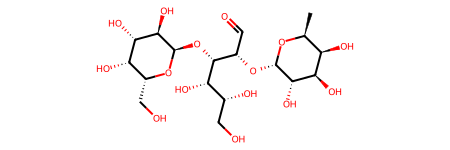

In [14]:
random.shuffle(mol_not_recovered)
for smi in mol_not_recovered[:10]:
    print(smi)
    mol = Chem.MolFromSmiles(smi)
    plot_mol(mol)
    file_name = "unrecovered_" + database_chosen + "_" + smi
    file_name = file_name.replace("/", "_fs_").replace("\\", "_bs_")
    # save_mol_plot(mol, file_name)

## Outliers

In [15]:
df_results_sorted_nmol = df_results.sort_values(by=["Nmol"], ascending=False)
print(list(df_results_sorted_nmol[df_results_sorted_nmol["Nmol"] >= 10]["Nmol"]))

[3558, 352, 288, 266, 192, 96, 67, 64, 57, 48, 48, 48, 48, 42, 41, 40, 36, 35, 32, 32, 32, 32, 32, 31, 31, 30, 30, 28, 28, 26, 26, 25, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 22, 21, 20, 20, 20, 20, 20, 19, 19, 19, 18, 18, 18, 18, 18, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


SMILES: C1CCC[C@H]2CCCN3CC[C@@H](CCCCCC[C@@H]4CCCN5CC[C@@H](CC1)O[C@@H]45)O[C@@H]23
Nb enumerated: 3558


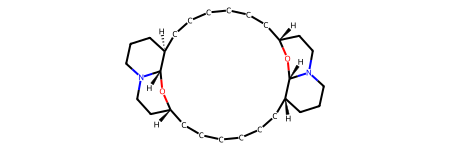

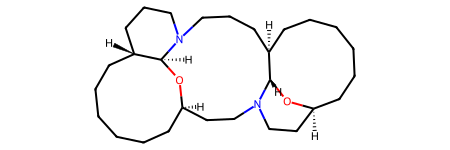

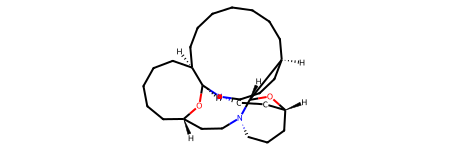

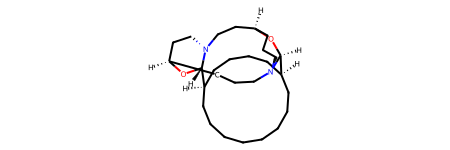

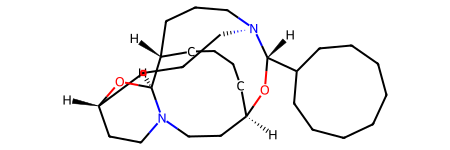

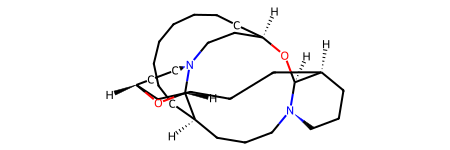

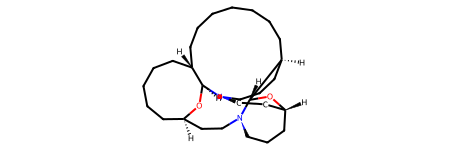

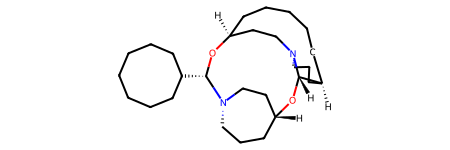

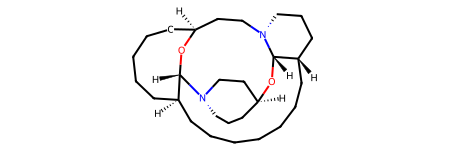

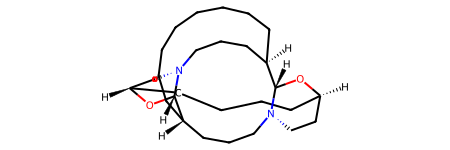

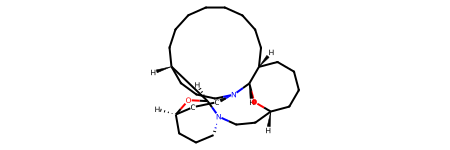

In [16]:
i = 0

smi_outlier = list(df_results_sorted_nmol["smi"])[i]
nb_enumerated = list(df_results_sorted_nmol["Nmol"])[i]
print(f"SMILES: {smi_outlier}")
print(f"Nb enumerated: {nb_enumerated}")
mol = Chem.MolFromSmiles(smi_outlier)
plot_mol(mol)
file_name = smi_outlier + "_nb_enum_" + str(nb_enumerated)
# save_mol_plot(mol, file_name)

mols_enum = list(df_results_sorted_nmol["NewSmiles"])[i]
mols_enum_trunc = mols_enum[: mols_enum.rfind(",")] + "}"
smiles_enum = list(ast.literal_eval(mols_enum_trunc))
random.shuffle(smiles_enum)

for j in range(10):
    smi = smiles_enum[j]
    mol = Chem.MolFromSmiles(smi)
    plot_mol(mol)
    file_name = smi_outlier + "_enum_" + str(j) + "_" + smi
    file_name = file_name.replace("/", "_fs_").replace("\\", "_bs_")
    # save_mol_plot(mol, file_name)

# Statistics generation

## Method choice

In [17]:
method_chosen = "top001"
# method_chosen = "top010"
# method_chosen = "top100"

In [18]:
df_results = pd.read_csv(
    path_results + "generative/" + database_chosen + "." + method_chosen + ".results.refined.tsv",
    sep="\t",
)
print(f"Results shape: {df_results.shape}")
df_results.head(1)

Results shape: (10000, 14)


,Query ID,Query SMILES,Query Counted ECFP,Predicted Tokens,Predicted Log Prob,Predicted Prob,Predicted SMILES,Predicted Counted ECFP,Predicted Canonic SMILES,Tanimoto Counted ECFP,SMILES Exact Match,Tanimoto Counted ECFP Exact Match,SMILES Syntaxically Valid,Time Elapsed
0,MNXM52680,CCN1C(=O)OC(C)(C)C1=O,19-34-80-233-255-294-314-314-324-351-576-588-6...,"[1, 18, 18, 22, 9, 18, 5, 15, 23, 6, 23, 18, 5...",-0.000355,0.999645,CCN1C(=O)OC(C)(C)C1=O,19-34-80-233-255-294-314-314-324-351-576-588-6...,CCN1C(=O)OC(C)(C)C1=O,1.0,True,True,True,0.23268


In [19]:
list_smiles = list(set(list(df_results["Query SMILES"])))
grouped = df_results.groupby("Query SMILES")["Tanimoto Counted ECFP"].apply(
    lambda col: int(1 in col.values)
)
# Only keep values for your specific list_smiles
mean_result = grouped.reindex(list_smiles, fill_value=0).mean()
print(f"Recovery % ecfp to mol: {round(100 * mean_result, 2)}")

Recovery % ecfp to mol: 79.41


In [20]:
list_smiles = list(df_results["Predicted Canonic SMILES"])
count_nan = sum(1 for x in list_smiles if isinstance(x, float) and math.isnan(x))
percent_nan = round(100 * count_nan / len(list_smiles), 2)
print(f"Number of NaN values: {count_nan} ; Percent: {percent_nan}")

Number of NaN values: 346 ; Percent: 3.46


In [21]:
tanimoto_list = list(df_results["Tanimoto Counted ECFP"])
tanimoto_list_no_nan = [x for x in tanimoto_list if not (isinstance(x, float) and math.isnan(x))]
print(len(tanimoto_list), len(tanimoto_list_no_nan))
print(f"Mean Tanimoto for non nan SMILES: {round(np.mean(tanimoto_list_no_nan), 2)}")

10000 9654
Mean Tanimoto for non nan SMILES: 0.96


In [22]:
mols_gen = list(set(list(df_results[df_results["Tanimoto Counted ECFP"] == 1]["Query SMILES"])))
mols_gen = list(set([Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in mols_gen]))
nb_mol_gen = len(mols_gen)
print(f"Nb molecules generated: {nb_mol_gen}")

Nb molecules generated: 7941


In [23]:
ct_ecfp_mol = np.mean(list(df_results["Time Elapsed"]))
print(f"Mean CT ecfp_mol: {round(ct_ecfp_mol, 2)}")

Mean CT ecfp_mol: 0.44


# Recovery enumeration by generation

In [24]:
df_results_enum = pd.read_excel(path_results + "RevSig_" + database_chosen + ".xlsx")
df_results_gen = pd.read_csv(
    path_results + "generative/" + database_chosen + ".top100.results.refined.tsv", sep="\t"
)
list_smiles = list(df_results_enum["smi"])

In [25]:
def predicted_smiles_by_enum(smi):
    df_enum_ID = df_results_enum[df_results_enum["smi"] == smi]

    smiles_enumerated = list(df_enum_ID["NewSmiles"])[0]
    if smiles_enumerated[-1] != ")" and smiles_enumerated[-1] != "}":
        smiles_enumerated = smiles_enumerated[: smiles_enumerated.rfind(",")] + "}"
    smiles_enumerated = set(list(ast.literal_eval(smiles_enumerated)))

    if list(df_enum_ID["Foundmol"])[0] == 1:
        smiles_enumerated.add(smi)
    if "[]" in smiles_enumerated:
        smiles_enumerated.remove("[]")
    if len(smiles_enumerated) != list(df_enum_ID["Nmol"])[0]:
        print(f"PB for smi: {smi}, nb enum: {list(df_enum_ID["Nmol"])[0]}")
        target_n = list(df_enum_ID["Nmol"])[0]
        current_n = len(smiles_enumerated)
        if current_n == 0:
            print(f"Cannot pad: smiles_enumerated is empty.")
        else:
            first_smi = list(smiles_enumerated)[0]
            for i in range(1, target_n - current_n + 1):
                smiles_enumerated.add(f"{first_smi}_{i}")
    return smiles_enumerated

In [26]:
def predicted_smiles_by_gen(smi):
    df_gen_ID = df_results_gen[df_results_gen["Query SMILES"] == smi]
    df_gen_ID_true = df_gen_ID[df_gen_ID["Tanimoto Counted ECFP"] == 1]
    list_smiles = set(df_gen_ID_true["Predicted Canonic SMILES"])
    list_smiles = set([Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in list_smiles])
    return list_smiles

In [27]:
i = 556
smi = list_smiles[i]
print(predicted_smiles_by_enum(smi))
print(predicted_smiles_by_gen(smi))

{'CC(C)[C@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](N)CC(=O)O)C(=O)O'}
{'CC(C)[C@H](NC(=O)[C@H](CCC(N)=O)NC(=O)[C@@H](N)CC(=O)O)C(=O)O'}


In [28]:
nb_intersection_total = 0
nb_total = 0
dict_recovery_per_class = {}
dict_enum = {}
dict_gen = {}
for i in range(len(list_smiles)):
    if i % 1000 == 0:
        print(i)
    smi = list_smiles[i]
    smiles_by_enum = predicted_smiles_by_enum(smi)
    nb_enum = len(smiles_by_enum)
    nb_total += nb_enum
    smiles_by_gen = predicted_smiles_by_gen(smi)
    nb_gen = len(smiles_by_gen)
    smiles_gen_enum_intersection = smiles_by_gen & smiles_by_enum
    nb_intersection = len(smiles_gen_enum_intersection)
    nb_intersection_total += nb_intersection

    if nb_enum in dict_recovery_per_class:
        dict_recovery_per_class[nb_enum][0] += nb_intersection
        dict_recovery_per_class[nb_enum][1] += nb_enum
        dict_recovery_per_class[nb_enum][2] += 1
    else:
        dict_recovery_per_class[nb_enum] = [nb_intersection, nb_enum, 1]

    if nb_enum in dict_enum:
        dict_enum[nb_enum] += 1
    else:
        dict_enum[nb_enum] = 1

    if nb_gen in dict_gen:
        dict_gen[nb_gen] += 1
    else:
        dict_gen[nb_gen] = 1

print("recovery total", 100 * nb_intersection_total / nb_total)

0
1000
2000
3000
4000
5000
6000
7000
PB for smi: C1CCC[C@H]2CCCN3CC[C@@H](CCCCCC[C@@H]4CCCN5CC[C@@H](CC1)O[C@@H]45)O[C@@H]23, nb enum: 3558
8000
9000
recovery total 57.686346343525436


- enumeration & generation

In [29]:
dict_sorted = dict(sorted(dict_enum.items()))  # enumeration
# dict_sorted = dict(sorted(dict_gen.items())) # generation

ranges = [
    ("0", lambda x: x == 0),
    ("1", lambda x: x == 1),
    ("2", lambda x: x == 2),
    ("3", lambda x: x == 3),
    ("4", lambda x: x == 4),
    ("5-9", lambda x: 5 <= x <= 9),
    ("10-14", lambda x: 10 <= x <= 14),
    ("15-19", lambda x: 15 <= x <= 19),
    ("20-24", lambda x: 20 <= x <= 24),
    ("25-inf", lambda x: x >= 25),
]

# Group by key and sum values
grouped_sums = defaultdict(int)

for key, value in dict_sorted.items():
    for label, condition in ranges:
        if condition(key):
            grouped_sums[label] += value
            break

# Display grouped sums
for label, _ in ranges:
    print(f"{label}: {grouped_sums[label]}")

0: 20
1: 8111
2: 1131
3: 35
4: 300
5-9: 228
10-14: 67
15-19: 42
20-24: 34
25-inf: 32


- recovery 

In [30]:
dict_recovery_per_class = dict(sorted(dict_recovery_per_class.items()))

ranges = [
    ("1", lambda x: x == 1),
    ("2", lambda x: x == 2),
    ("3", lambda x: x == 3),
    ("4", lambda x: x == 4),
    ("5-9", lambda x: 5 <= x <= 9),
    ("10-14", lambda x: 10 <= x <= 14),
    ("15-19", lambda x: 15 <= x <= 19),
    ("20-24", lambda x: 20 <= x <= 24),
    ("25-inf", lambda x: x >= 25),
]

grouped_values = defaultdict(list)

for x in dict_recovery_per_class:
    if x == 0:
        continue

    values = dict_recovery_per_class[x]
    recovered = values[0]
    total = values[1]

    if total == 0:
        continue

    percent = 100 * recovered / total

    for label, condition in ranges:
        if condition(x):
            grouped_values[label].append(percent)
            break

for label, _ in ranges:
    values = grouped_values[label]
    mean_val = round(sum(values) / len(values), 1) if values else float("nan")
    print(f"{label}: {mean_val}%")

1: 95.9%
2: 77.9%
3: 43.8%
4: 54.6%
5-9: 57.0%
10-14: 75.4%
15-19: 60.8%
20-24: 52.2%
25-inf: 28.8%


# Create Excel supplementary

In [31]:
df_results_enum = pd.read_excel(path_results + "RevSig_" + database_chosen + ".xlsx")
df_results_enum.head(1)

,ID,smi,wt,Nsig,NsigTrue,FoundSig,Nmol,Foundmol,CT ecfp_sig,CT sig_mol,CT ecfp_mol,CT solve_partitions,ThresholdPart,ThresholdRec,NewSmiles
0,0,CCN1C(=O)OC(C)(C)C1=O,157.073893,1,1,1,1,1,1.342747,0.018277,1.361032,0.001598,False,False,set()


In [32]:
method_chosen = "top001"
df_results_gen_top001 = pd.read_csv(
    path_results + "generative/" + database_chosen + "." + method_chosen + ".results.refined.tsv",
    sep="\t",
)
method_chosen = "top010"
df_results_gen_top010 = pd.read_csv(
    path_results + "generative/" + database_chosen + "." + method_chosen + ".results.refined.tsv",
    sep="\t",
)
method_chosen = "top100"
df_results_gen_top100 = pd.read_csv(
    path_results + "generative/" + database_chosen + "." + method_chosen + ".results.refined.tsv",
    sep="\t",
)
df_results_gen_top001.head()

,Query ID,Query SMILES,Query Counted ECFP,Predicted Tokens,Predicted Log Prob,Predicted Prob,Predicted SMILES,Predicted Counted ECFP,Predicted Canonic SMILES,Tanimoto Counted ECFP,SMILES Exact Match,Tanimoto Counted ECFP Exact Match,SMILES Syntaxically Valid,Time Elapsed
0,MNXM52680,CCN1C(=O)OC(C)(C)C1=O,19-34-80-233-255-294-314-314-324-351-576-588-6...,"[1, 18, 18, 22, 9, 18, 5, 15, 23, 6, 23, 18, 5...",-0.000355,0.999645,CCN1C(=O)OC(C)(C)C1=O,19-34-80-233-255-294-314-314-324-351-576-588-6...,CCN1C(=O)OC(C)(C)C1=O,1.0,True,True,True,0.232680
1,MNXM1161300,CC(=O)NC[C@H](O)c1c[nH]c(C(=O)[O-])c1C(=O)[O-],1-80-125-154-197-227-237-245-347-586-606-650-6...,"[1, 18, 18, 5, 15, 23, 6, 22, 18, 29, 5, 23, 6...",-0.000081,0.999919,CC(=O)NC[C@H](O)c1c[nH]c(C(=O)[O-])c1C(=O)[O-],1-80-125-154-197-227-237-245-347-586-606-650-6...,CC(=O)NC[C@H](O)c1c[nH]c(C(=O)[O-])c1C(=O)[O-],1.0,True,True,True,0.347055
2,MNXM1114727,Nc1nc(N2CCC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,49-80-128-130-194-222-255-378-378-378-407-409-...,"[1, 22, 42, 9, 43, 42, 5, 22, 10, 18, 18, 18, ...",-0.018720,0.981454,Nc1nc(N2CCC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,49-80-128-130-194-222-255-378-378-378-407-409-...,Nc1nc(N2CCC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,1.0,True,True,True,0.386471
3,MNXM806648,C[C@H](CO)C(=O)O[C@@H]1O[C@H](C(=O)O)[C@H](O)[...,1-80-147-222-283-301-363-389-482-490-521-559-6...,"[1, 18, 29, 5, 18, 23, 6, 18, 5, 15, 23, 6, 23...",-0.000055,0.999945,C[C@H](CO)C(=O)O[C@@H]1O[C@H](C(=O)O)[C@H](O)[...,1-80-147-222-283-301-363-389-482-490-521-559-6...,C[C@H](CO)C(=O)O[C@@H]1O[C@H](C(=O)O)[C@H](O)[...,1.0,True,True,True,0.375897
4,MNXM1256019,C[C@H](CCCCCCCCCCN(C)C)[C@H](CC(=O)[O-])C(=O)[O-],1-1-48-80-80-80-80-80-80-80-80-80-80-80-169-23...,"[1, 18, 29, 5, 18, 18, 18, 18, 18, 18, 18, 18,...",-0.084072,0.919365,C[C@H](CCCCCCCCCCN(C)C)[C@H](CC(=O)[O-])C(=O)[O-],1-1-48-80-80-80-80-80-80-80-80-80-80-80-169-23...,C[C@H](CCCCCCCCCCN(C)C)[C@H](CC(=O)[O-])C(=O)[O-],1.0,True,True,True,0.370256


In [33]:
list_smiles = list(df_results_enum["smi"])

In [34]:
def predicted_smiles_by_gen_method_chosen(smi, method_chosen):
    if method_chosen == "top001":
        df_gen_ID = df_results_gen_top001[df_results_gen_top001["Query SMILES"] == smi]
    elif method_chosen == "top010":
        df_gen_ID = df_results_gen_top010[df_results_gen_top010["Query SMILES"] == smi]
    else:
        df_gen_ID = df_results_gen_top100[df_results_gen_top100["Query SMILES"] == smi]
    df_gen_ID_true = df_gen_ID[df_gen_ID["Tanimoto Counted ECFP"] == 1]
    list_smiles = set(df_gen_ID_true["Predicted Canonic SMILES"])
    list_smiles = set([Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in list_smiles])
    return list_smiles

In [35]:
list_idx = []
list_enum = []
list_gen_001 = []
list_gen_010 = []
list_gen_100 = []
for i in range(len(list_smiles)):
    if i > 0 and i % 1000 == 0:
        print(i)
    smi = list_smiles[i]
    smi_idx = list(df_results_gen_top001[df_results_gen_top001["Query SMILES"] == smi]["Query ID"])[
        0
    ]
    list_idx.append(smi_idx)
    list_enum.append(list(predicted_smiles_by_enum(smi)))
    list_gen_001.append(list(predicted_smiles_by_gen_method_chosen(smi, "top001")))
    list_gen_010.append(list(predicted_smiles_by_gen_method_chosen(smi, "top010")))
    list_gen_100.append(list(predicted_smiles_by_gen_method_chosen(smi, "top100")))

1000
2000
3000
4000
5000
6000
7000
PB for smi: C1CCC[C@H]2CCCN3CC[C@@H](CCCCCC[C@@H]4CCCN5CC[C@@H](CC1)O[C@@H]45)O[C@@H]23, nb enum: 3558
8000
9000


In [36]:
df = pd.DataFrame(
    {
        "ID": list_idx,
        "SMILES": list_smiles,
        "Enumeration: SMILES": list_enum,
        "Generation TOP1: SMILES": list_gen_001,
        "Generation TOP10: SMILES": list_gen_010,
        "Generation TOP100: SMILES": list_gen_100,
    }
)

# df.to_excel("Dataset Enumeration Generation.xlsx")